# Sentiment Analysis Project

## Overview
This project classifies tweets as hate speech, offensive language, or neither using deep learning. It involves preprocessing text data and training an LSTM-based neural network using TensorFlow/Keras.

## 1. Import Required Libraries
Note: You may encounter several errors or warnings related to TensorFlow package downloads, but these will not affect the functionality or accuracy of the model. Optionally, to remove the warnings, you can run the following code underneath:

```import warnings```
<br>
```warnings.filterwarnings('ignore')```

In [1]:
import pandas as pd 
import numpy as np
import nltk 
from tqdm import tqdm
from nltk.corpus import stopwords 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow import keras
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

2025-08-05 22:21:38.404872: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 22:21:38.407866: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-05 22:21:38.440717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-05 22:21:38.440751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-05 22:21:38.441640: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## 2. Load and Inspect the Dataset

In [2]:
df = pd.read_csv("labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## 3. Data Cleaning/Preprocessing 

In [3]:
df.drop(columns = ["Unnamed: 0"], inplace = True)

In [4]:
df.rename(columns = {'class': 'label', 'tweet': 'text'}, inplace = True)

In [5]:
df.isna().sum()
df['text'].iloc[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

### Remove Stopwords
Stopwords are words such as articles (a, an, the), prepositions (in, on, at), conjunctions (and, but, or), and pronouns (I, he, she) that have little to no significance when it comes natural language processing. Thus, the removal of stopwords will allow the model to be more accurate and robust. 

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /opt/conda/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /opt/conda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /opt/conda/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
stop_words = set(stopwords.words('english'))
len(stop_words)
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [8]:
def remove_stopwords(text: str):
    if pd.isnull(text):
        return ""
    all_words = nltk.word_tokenize(text)
    filtered  = [word for word in all_words if word.lower() not in stop_words]
    return " ".join(filtered)

In [9]:
df.loc[:10, 'text'] = df.loc[:10, 'text'].apply(remove_stopwords)

In [10]:
# Since there is many rows of data, the tokenize() function is very costly in terms of time complexity 
# Process takes around 6 minutes for completion  
tqdm.pandas()
df['text'] = df['text'].progress_apply(remove_stopwords)

100%|██████████| 24783/24783 [04:30<00:00, 91.73it/s]


In [ ]:
df

### Tokenization and Pad Text Sequences

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

In [13]:
sequences = tokenizer.texts_to_sequences(df['text'])

In [14]:
df['text'].iloc[0]

"! ! ! RT @ mayasolovely : woman n't complain cleaning house . & amp ; man always take trash ..."

In [15]:
max_len = 50

padded_sequences = pad_sequences(sequences, maxlen = max_len, padding = 'post')

In [16]:
# making the labels into a numpy array format 
labels = np.array(df['label'])

In [17]:
labels

array([2, 1, 1, ..., 1, 1, 2])

## 4. Define Model Architecture

### Input Layer 
Necessary to accept the input (in the form of padded sequences)

In [18]:
# preparing the inputs first 

input_layer = keras.layers.Input(shape = (max_len,), name = 'padded_sequences')

### Embedding Layer 
Converts word indices into dense vectors of fixed size (128)

In [19]:
embedding_layer = keras.layers.Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 128)
embedding = embedding_layer(input_layer)

### LSTM Layer 
Captures sequential patterns and dependencies in the text like the word order 

In [20]:
shared_lstm = keras.layers.LSTM(70, return_sequences = True)
lstm = shared_lstm(embedding)

### Global Average Pooling Layer
Reduces the sequence output to a fixed-size vector by averaging over time steps 

In [27]:
shared_pooling = keras.layers.GlobalAveragePooling1D()

### Dropout Layer 
Randomly sets 50% of inputs to zero during training (helpful to prevent overfitting of the model)

In [ ]:
shared_dropout = keras.layers.Dropout(0.5)

In [22]:
features = shared_dropout(shared_pooling(lstm))

# Output Layer 
Showcases result of the model by classifying text as either hateful, offensive, or neither 

In [23]:
output = keras.layers.Dense(3, activation = 'softmax', name = 'output')(features)

In [ ]:
model = keras.models.Model(inputs = [input_layer], outputs = [output])
model.compile(optimizer = 'adam', loss = {'output': 'sparse_categorical_crossentropy'}, metrics = {'output': 'accuracy'})


### Model Summary (High-Level Flow):
Input → Embedding → LSTM → Pooling → Dropout → Dense Output

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 padded_sequences (InputLay  [(None, 50)]              0         
 er)                                                             
                                                                 
 embedding (Embedding)       (None, 50, 128)           4594176   
                                                                 
 lstm (LSTM)                 (None, 50, 70)            55720     
                                                                 
 global_average_pooling1d (  (None, 70)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 output (Dense)              (None, 3)                 213   

In [26]:
model.fit(x=padded_sequences, y=labels, epochs=10, batch_size=4)

Epoch 1/10
6196/6196 [==============================] - 143s 23ms/step - loss: 0.3808 - accuracy: 0.8743
Epoch 2/10
6196/6196 [==============================] - 143s 23ms/step - loss: 0.2246 - accuracy: 0.9242
Epoch 3/10
6196/6196 [==============================] - 142s 23ms/step - loss: 0.1284 - accuracy: 0.9581
Epoch 4/10
6196/6196 [==============================] - 142s 23ms/step - loss: 0.0684 - accuracy: 0.9772
Epoch 5/10
6196/6196 [==============================] - 143s 23ms/step - loss: 0.0386 - accuracy: 0.9878
Epoch 6/10
6196/6196 [==============================] - 142s 23ms/step - loss: 0.0248 - accuracy: 0.9919
Epoch 7/10
6196/6196 [==============================] - 141s 23ms/step - loss: 0.0190 - accuracy: 0.9939
Epoch 8/10
6196/6196 [==============================] - 141s 23ms/step - loss: 0.0154 - accuracy: 0.9949
Epoch 9/10
6196/6196 [==============================] - 140s 23ms/step - loss: 0.0100 - accuracy: 0.9967
Epoch 10/10
6196/6196 [==============================] 

In [46]:
predictions = model.predict({'padded_sequences': padded_sequences})

775/775 [==============================] - 4s 6ms/step


## 5. Accuracy and Validation

#### Key Performance Metrics
- **Overall Accuracy**: 99.8%
- **Hate Speech**: 98.0% recall, ~98.3% precision
- **Offensive Language**: 100% recall, ~99.7% precision  
- **Neither**: 100% recall, ~99.9% precision

#### Key Observations
- **Exceptional overall performance** with near-perfect classification across all categories
- **Strongest detection** for "Neither" and "Offensive" categories (perfect recall)
- **Minimal misclassification** with all confusion values ≤ 0.017
- **Reliable content moderation** capability with very low false positive rates
- **Hate speech detection** shows slightly lower (but still excellent) performance at 98%

In [47]:
preds = np.argmax(predictions, axis = 1)

In [54]:
def plot_confusion_matrix(true, pred, title, labels):
    cf = confusion_matrix(true, pred, normalize = 'true')
    plt.figure(figsize = (7, 6))
    sns.heatmap(cf, annot = True, cmap = "Blues", xticklabels = labels, yticklabels = labels)
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Prediction")

hate = ['hate', 'offensive', 'neither']

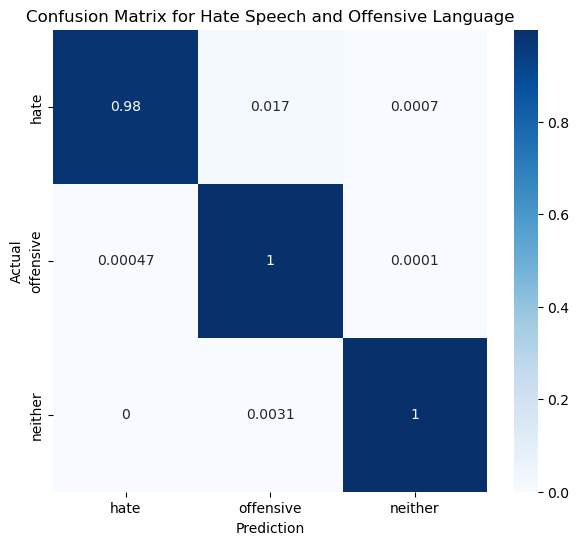

In [55]:
plot_confusion_matrix(labels, preds, "Confusion Matrix for Hate Speech and Offensive Language", hate)

## 6. Predictions 

In [58]:
def predict_text(input_text):
    # Clean and preprocess the input
    tokens = nltk.word_tokenize(input_text)
    filtered = [word for word in tokens if word.lower() not in stop_words]
    cleaned_text = " ".join(filtered)

    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(seq, maxlen=50, padding='post')

    prediction = model.predict(padded_seq)
    pred_class = np.argmax(prediction, axis=1)[0]

    label_map = {0: 'hate', 1: 'offensive', 2: 'neither'}
    predicted_label = label_map[pred_class]
    confidence = prediction[0][pred_class]

    print(f"Input Text: {input_text}")
    print(f"Predicted Label: {predicted_label} (Confidence: {confidence:.2f})")

    return predicted_label


Enter text enclosed by quotation marks (" ") starting and ending to see how the model works!
<br>
Example: ```predict_text("coding is amazing")```

In [69]:
predict_text()

TypeError: predict_text() missing 1 required positional argument: 'input_text'